In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report


def merge_labels(label: str) -> str:
    if label in ["DAC", "IAC"]:
        return "AC"
    elif label in ["DQC", "IQC"]:
        return "QC"
    else:
        return label


Processing property: Material type


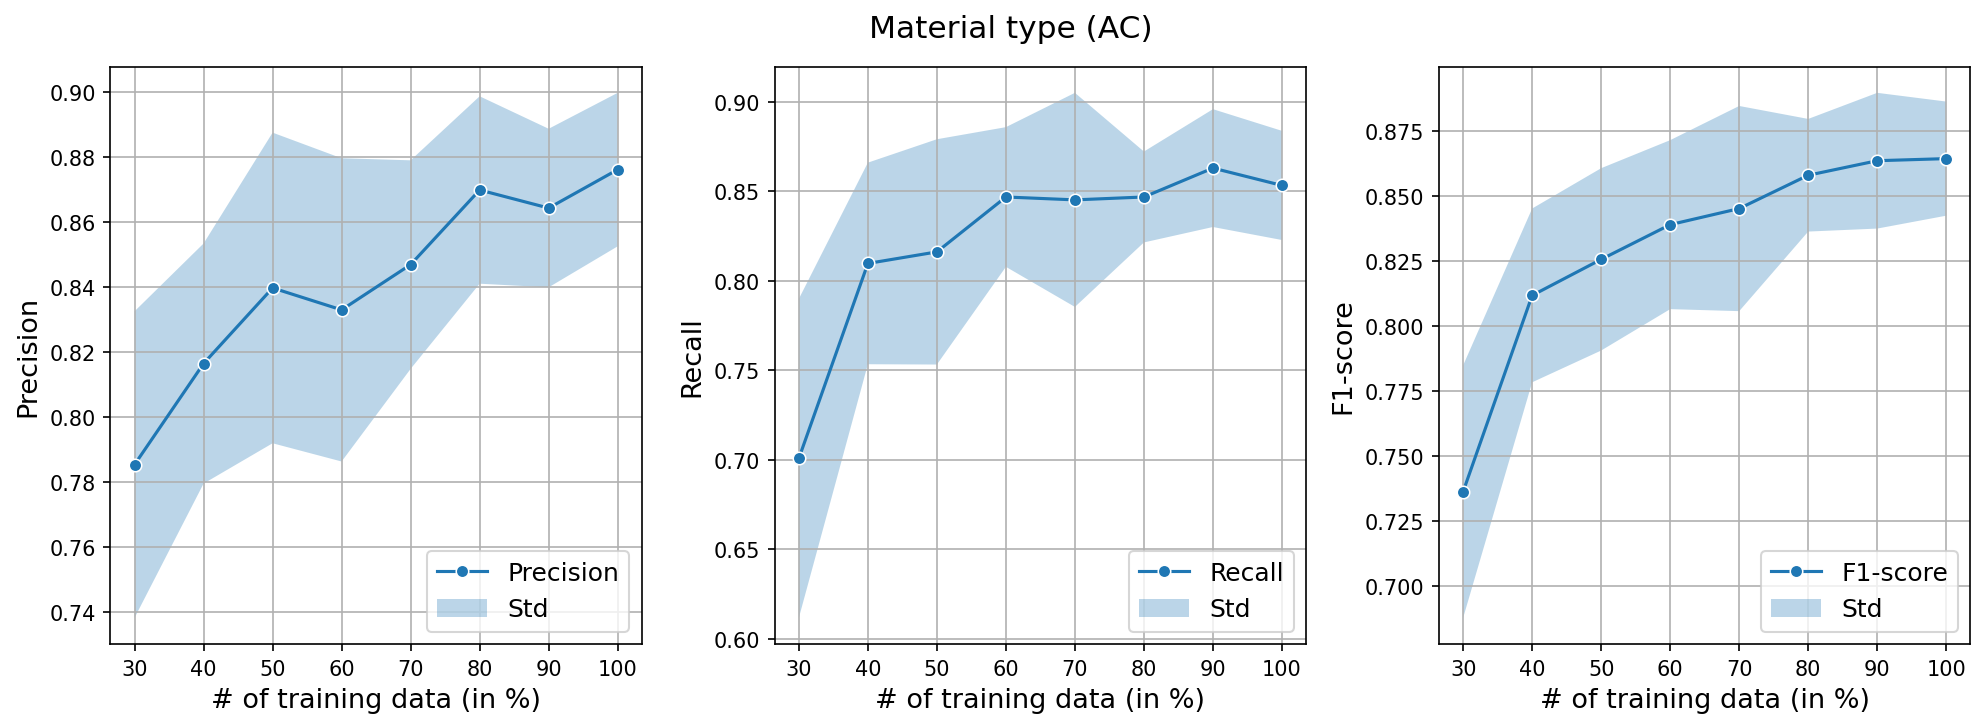

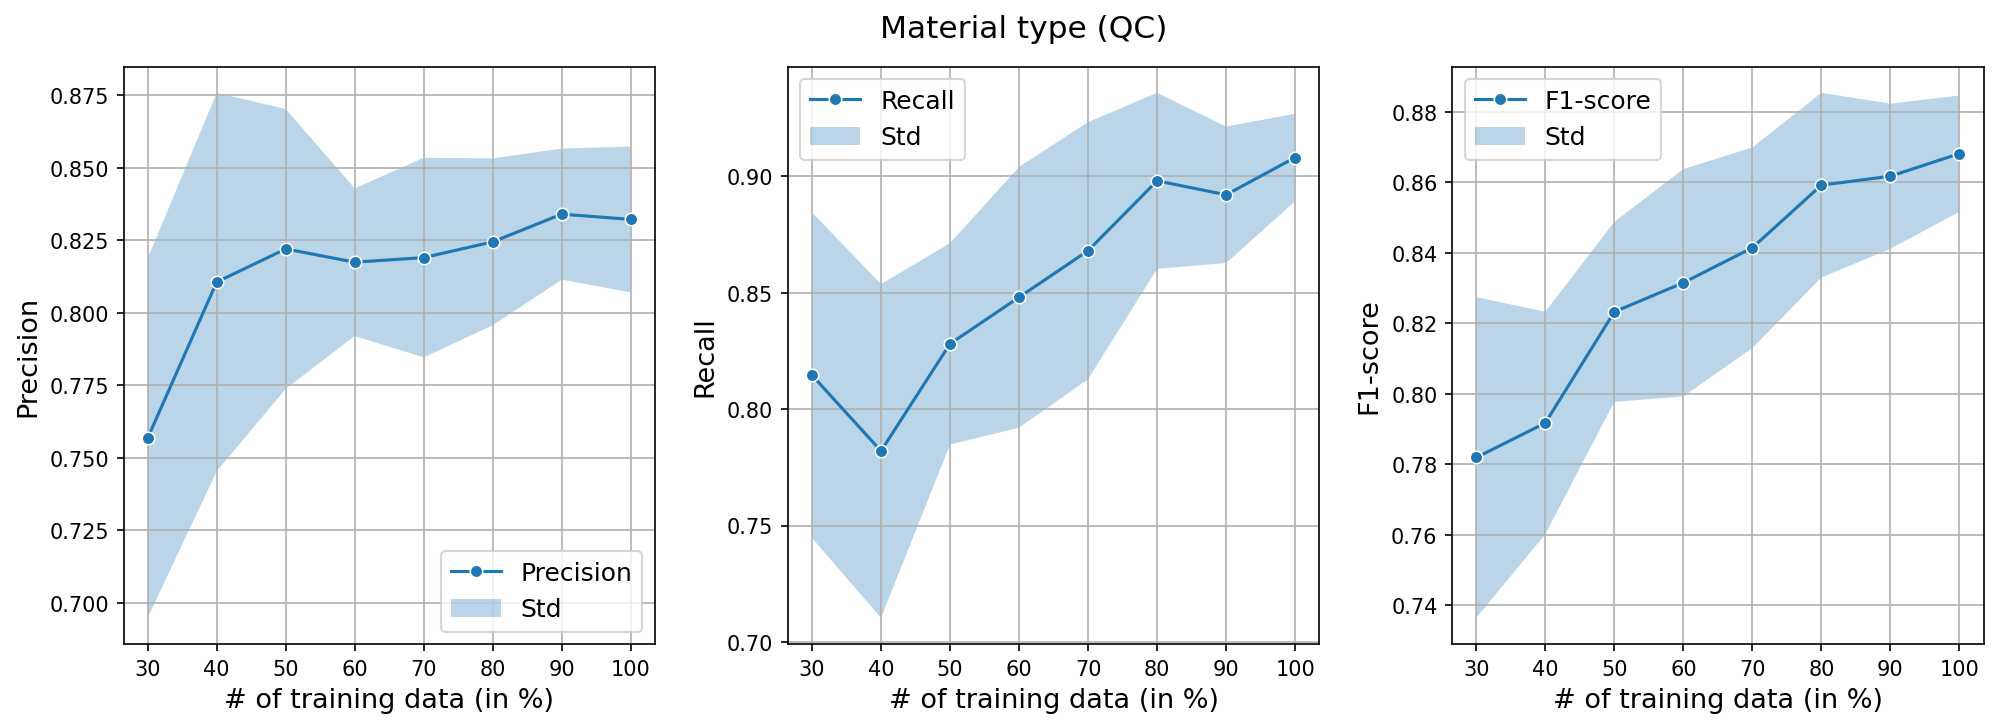

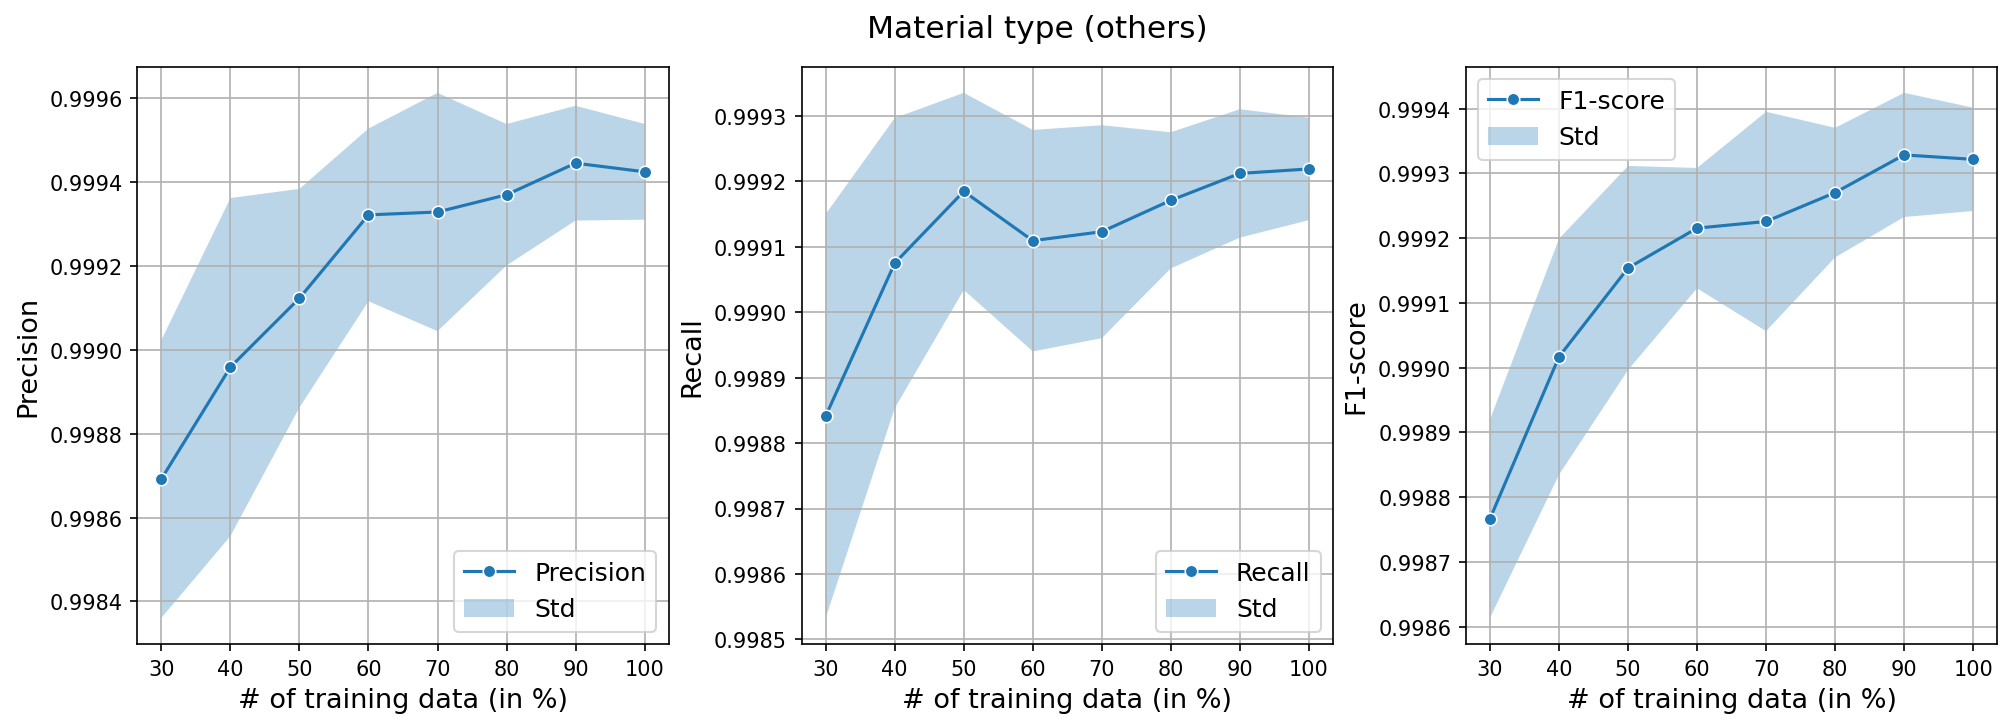

In [12]:
for prop_name in ["Material type"]:
    print(f"Processing property: {prop_name}")

    # 定义 prediction 文件夹路径
    prediction_dir = Path(f"notebooks/logs/classification/{prop_name}")

    # # 用于存储所有 trial 的 results
    metrics_list = []

    for result_dir in prediction_dir.iterdir():
        if result_dir.is_dir() and result_dir.name not in [
            ".ipynb_checkpoints",
            "summary",
            "summary_reduce_to_QCACothers",
        ]:
            ratio = result_dir.name.split("_")[-1]
            ratio = float(ratio[1:])
            for pred_dir in (result_dir / "predictions").iterdir():
                if pred_dir.is_dir() and pred_dir.name.startswith("trial_"):
                    n_trial = int(pred_dir.name.split("_")[-1])
                    results_path = pred_dir / "clf_predictions.csv"
                    if results_path.exists():
                        results = pd.read_csv(results_path)
                        results = results[results.label == "test"]
                        y_true = results.y_true.apply(merge_labels)
                        y_pred = results.y_pred.apply(merge_labels)
                        test_report = classification_report(
                            y_true, y_pred, target_names=["QC", "AC", "others"], digits=4, output_dict=True
                        )

                        # 只提取 DAC 的指标
                        metrics_list.append(
                            {
                                "precision": test_report["AC"]["precision"],
                                "recall": test_report["AC"]["recall"],
                                "f1-score": test_report["AC"]["f1-score"],
                                "type": "AC",
                                "ratio": ratio,
                                "trial": n_trial,
                            }
                        )
                        metrics_list.append(
                            {
                                "precision": test_report["QC"]["precision"],
                                "recall": test_report["QC"]["recall"],
                                "f1-score": test_report["QC"]["f1-score"],
                                "type": "QC",
                                "ratio": ratio,
                                "trial": n_trial,
                            }
                        )
                        metrics_list.append(
                            {
                                "precision": test_report["others"]["precision"],
                                "recall": test_report["others"]["recall"],
                                "f1-score": test_report["others"]["f1-score"],
                                "type": "others",
                                "ratio": ratio,
                                "trial": n_trial,
                            }
                        )

    # # 整理成 DataFrame
    df_metrics = pd.DataFrame(metrics_list).sort_values(by=["ratio", "trial"])

    # 保存df_metrics为csv和parquet格式
    summary_dir = prediction_dir / "summary_reduce_to_QCACothers"
    summary_dir.mkdir(parents=True, exist_ok=True)
    df_metrics.to_csv(summary_dir / "df_metrics.csv", index=False)
    df_metrics.to_parquet(summary_dir / "df_metrics.parquet", index=False)

    grouped = df_metrics.groupby(["type", "ratio"])[["precision", "recall", "f1-score"]]
    mean_ = grouped.mean()
    std_ = grouped.std().loc[mean_.index]

    mean_ = mean_.reset_index()
    std_ = std_.reset_index()

    for t, _mean in mean_.groupby("type"):
        _std = std_[std_["type"] == t]
        percent_index = _mean.ratio * 100
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), dpi=150)
        plt.subplots_adjust(wspace=0.25)
        sns.lineplot(x=percent_index, y=_mean["precision"].values, marker="o", ax=ax1, label="Precision")
        ax1.fill_between(
            percent_index,
            _mean["precision"].values - _std["precision"].values,
            _mean["precision"].values + _std["precision"].values,
            alpha=0.3,
            label="Std",
        )
        ax1.set_xlabel("# of training data (in %)", fontsize=13)
        ax1.set_ylabel("Precision", fontsize=13)
        ax1.legend(fontsize=12)
        ax1.grid(True)

        sns.lineplot(x=percent_index, y=_mean["recall"].values, marker="o", ax=ax2, label="Recall")
        ax2.fill_between(
            percent_index,
            _mean["recall"].values - _std["recall"].values,
            _mean["recall"].values + _std["recall"].values,
            alpha=0.3,
            label="Std",
        )
        ax2.set_xlabel("# of training data (in %)", fontsize=13)
        ax2.set_ylabel("Recall", fontsize=13)
        ax2.legend(fontsize=12)
        ax2.grid(True)

        sns.lineplot(x=percent_index, y=_mean["f1-score"].values, marker="o", ax=ax3, label="F1-score")
        ax3.fill_between(
            percent_index,
            _mean["f1-score"].values - _std["f1-score"].values,
            _mean["f1-score"].values + _std["f1-score"].values,
            alpha=0.3,
            label="Std",
        )
        ax3.set_xlabel("# of training data (in %)", fontsize=13)
        ax3.set_ylabel("F1-score", fontsize=13)
        ax3.legend(fontsize=12)
        ax3.grid(True)
        fig.suptitle(
            f"{prop_name} ({t})",
            fontsize=15,
            y=0.95,
        )

        # 保存fig为png格式
        fig.savefig(summary_dir / f"{t}_metrics_plot.png", bbox_inches="tight", dpi=200)

        plt.show()